# Import Character Vocab


In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
import numpy as np
import json
import tensorflow as tf
import pandas as pd

from src.config import vocab

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
CHAR_INDICES = vocab

In [6]:
print(CHAR_INDICES)

({' ': 0, '(': 1, ')': 2, ',': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'Q': 31, 'R': 32, 'S': 33, 'T': 34, 'U': 35, 'V': 36, 'W': 37, 'X': 38, 'Y': 39, 'Z': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66, '[': 67, ']': 68, '<pad>': 69, '<unk>': 70, '.': 71, "'": 72},)


# Preprocessing text data

## look_back

In [7]:
look_back = 10

In [8]:
def create_dataset(text, look_back = look_back):

  """
  take text with label (text that being defined where to cut ('|')) 
  and encode text and make label
  return preprocessed text & preprocessed label
  """
  X, y = [], []
  text = '|' + text
  data = [CHAR_INDICES['<pad>']] * look_back
  for i in range(1, len(text)):
    current_char = text[i]
    before_char = text[i-1]

    if current_char == '|':
      continue
    data = data[1:] + [CHAR_INDICES[current_char]]  # X data

    target = 1 if before_char == '|' else 0  # y data
    X.append(data)
    y.append(target)
  
  return np.array(X), tf.one_hot(y, 2)

In [9]:
def text_pred_preprocessing(text, sequence_len=look_back):
  """
    take unseen (testing) text and encode it with CHAR_DICT
    //It's like create_dataset() but not return label
    return preprocessed text
  """
  X = []
  data = [CHAR_INDICES['<pad>']] * sequence_len
  for char in text:
    char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
    data = data[1:] + [CHAR_INDICES[char]]  # X data
    X.append(data)
  return np.array(X)

In [10]:
def word_tokenize(text, class_):
    cut_indexs = []
    words = []

    # boolean index of each word 1 if cut before
    class_ = np.append(class_, 1)

    # if y_label at i is 1 so add i (index) to cut_indexs
    for i, value in enumerate(class_):
      if value == 1:
        cut_indexs.append(i)

    # add word after cutting till before ext cutting
    for i in range(len(cut_indexs)-1):
      words.append(text[cut_indexs[i]:cut_indexs[i+1]])
    
    return words

In [11]:
def decode_label(y):
  return tf.argmax(y, axis=-1).numpy()

## Import Dataset

In [12]:
df_train = pd.read_csv('../Making_Datasets/dataframe/df_train.csv')
df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Making_Datasets/dataframe/df_train.csv'

In [ ]:
df_val = pd.read_csv('../Making_Datasets/dataframe/df_val.csv')
df_val.head()

,index,cid,iupacname,label,file_names
0,216886,102476271,"methyl (2R,3R)-2-amino-3-hydroxy-3-(3-methylph...","meth|yl| |(|2|R|,|3|R|)|-|2|-|amino|-|3|-|hydr...",102476271.png
1,196002,57375822,tert-butyl 2-amino-3-pyridin-3-ylpropanoate,tert|-|but|yl| |2|-|amino|-|3|-|pyridin|-|3|-|...,57375822.png
2,170094,16099663,ethyl 3-methyl-2-oxocyclohex-3-ene-1-carboxylate,eth|yl| |3|-|meth|yl|-|2|-|oxo|cyclo|hex|-|3|-...,16099663.png
3,291564,93972463,methyl (2S)-2-hydroxybut-3-enoate,meth|yl| |(|2S|)|-|2|-|hydroxy|but|-|3|-|en|oate,93972463.png
4,273267,85736,butan-2-yl 2-cyanoacetate,but|an|-|2|-|yl| |2|-|cyano|acet|ate,85736.png


In [13]:
df_test= pd.read_csv('../Making_Datasets/dataframe/df_test.csv')
df_test.head()

FileNotFoundError: [Errno 2] No such file or directory: '../Making_Datasets/dataframe/df_test.csv'

In [ ]:
def prepare_text_dataset(arr_iupac, arr_label):
  return ' '.join(arr_iupac), '|'.join(arr_label)

In [ ]:
text_train, text_cut_train = prepare_text_dataset(df_train['iupacname'].values, df_train['label'].values)
text_val, text_cut_val = prepare_text_dataset(df_val['iupacname'].values, df_val['label'].values)
text_test, text_cut_test = prepare_text_dataset(df_test['iupacname'].values, df_test['label'].values)

print(text_train[:10], '++', text_cut_train[:20])
print(text_val[:10], '++', text_cut_val[:20])
print(text_test[:10], '++', text_cut_test[:20])

2-fluoroet ++ 2|-|fluoro|eth|yl| |
methyl (2R ++ meth|yl| |(|2|R|,|3|
(3-methylo ++ (|3|-|meth|yl|oxan|-


In [ ]:
X_train ,y_train = create_dataset(text_cut_train)
X_val, y_val = create_dataset(text_cut_val)
X_test, y_test = create_dataset(text_cut_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10203080, 10) (10203080, 2)
(2185999, 10) (2185999, 2)
(2187981, 10) (2187981, 2)


In [ ]:
training_data = tf.data.Dataset.from_tensor_slices((tf.cast(X_train, tf.float32),y_train))
training_data = training_data.shuffle(222623).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((tf.cast(X_val, tf.float32), y_val))
validation_data = validation_data.shuffle(47381).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

testing_data = tf.data.Dataset.from_tensor_slices((tf.cast(X_test, tf.float32), y_test))
testing_data = testing_data.shuffle(48552).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)


# Create Model

## Model Architecture

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, GRU, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [ ]:
_input_shape = (look_back, len(CHAR_INDICES))
print(_input_shape[1])

73


In [ ]:
Model = Sequential(
    [
    tf.keras.layers.Input((look_back,), dtype=tf.float16),
    Embedding(len(CHAR_INDICES), 64, input_length= look_back),

    #Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'),
    #MaxPooling1D(pool_size=2),
     
    Bidirectional(GRU(32, return_sequences=False), merge_mode='sum'),
    Dropout(0.5),

    Dense(2, activation='softmax'),
    tf.keras.layers.Activation('softmax', dtype=tf.float32)
    ],
    name='model'
)

In [ ]:
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 64)            4672      
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                18816     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 23,554
Trainable params: 23,554
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# tf.keras.utils.plot_model(Model, to_file='model.png', show_shapes=True, dpi=60)

## Training Model (with callback)


In [ ]:
# Stacking Bi-GRU
## (9s) loss: 0.3269 - accuracy: 0.9988 - val_loss: 0.3287 - val_accuracy: 0.9974

# Bi-GRU
## (7s) loss: 0.3277 - accuracy: 0.9982 - val_loss: 0.3292 - val_accuracy: 0.9970

# Stacking Bi-LSTM
## (9s) loss: 0.3269 - accuracy: 0.9988 - val_loss: 0.3290 - val_accuracy: 0.9974

# Bi-LSTM
## (6s) loss: 0.3280 - accuracy: 0.9981 - val_loss: 0.3297 - val_accuracy: 0.9968

In [ ]:
Model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
    metrics=['accuracy']
)

checkpoint_path = 'save_models/best_model.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    include_optimizer=False,
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True
)

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
    verbose=1, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

callback_list = [earlystop_callback, reduce_lr]

In [ ]:
history = Model.fit(training_data, validation_data=validation_data, epochs=100, callbacks=callback_list)

Epoch 1/100
19941/79712 [======>.......................] - ETA: 16:46 - loss: 0.4264 - accuracy: 0.9835

In [ ]:
X_test, y_test = create_dataset(text_cut_test)
print(y_test.shape)

Model.evaluate(X_test, y_test)

(47921, 2)
1498/1498 [==============================] - 4s 3ms/step - loss: 0.3280 - accuracy: 0.9981


[0.328036367893219, 0.9981219172477722]

##  Plot loss function and accuracy

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


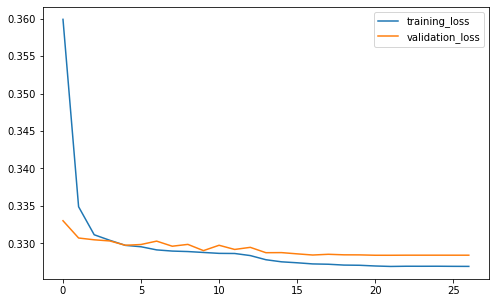

In [ ]:
print(type(history.history))
print(history.history.keys())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

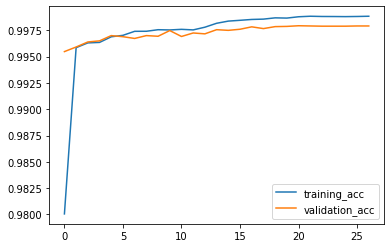

In [ ]:
plt.plot(history.history['accuracy'], label='training_acc')
plt.plot(history.history['val_accuracy'], label='validation_acc')
plt.legend()
plt.show()

# Import model and Test on unseen data

In [ ]:
best_model = tf.keras.models.load_model('save_models/best_model.hdf5')
#best_model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
test_data_text = '3-[3-(bromomethyl)-4-hydroxyphenyl]propanoic acid'
test_data_text_cut = '3|-|[|3|-|(|bromo|meth|yl|)|-|4|-|hydroxy|phen|yl|]|prop|an|oic acid'

In [ ]:
_, my_y = create_dataset(test_data_text_cut)
myText_test = text_pred_preprocessing(test_data_text)

pred_test_proba = best_model.predict(myText_test)

pred_test = decode_label(pred_test_proba)
pred_test[0] = 1
my_y_decode = decode_label(my_y)

print(pred_test)
#print(my_y_decode)

# Count same item between y (label) and pred (prediction)
elem_same = (pred_test == my_y_decode).sum()
print("\nSame =",elem_same,", Not Same =",pred_test.shape[0]-elem_same)

[1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0
 0 0 1 0 1 0 0 0 0 0 0 0]

Same = 49 , Not Same = 0


In [ ]:
words = word_tokenize(test_data_text, pred_test)
print(words)
print('|'.join(words))

['3', '-', '[', '3', '-', '(', 'bromo', 'meth', 'yl', ')', '-', '4', '-', 'hydroxy', 'phen', 'yl', ']', 'prop', 'an', 'oic acid']
3|-|[|3|-|(|bromo|meth|yl|)|-|4|-|hydroxy|phen|yl|]|prop|an|oic acid


# Function Confusion Matrix visualization

# Plot Confusion Matrix

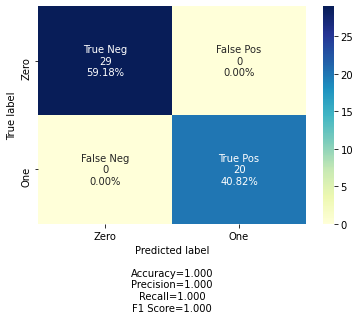

In [ ]:
from nami.visualize import plot_confusion_matrix
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Zero", "One"]
plot_confusion_matrix(tf.math.confusion_matrix(my_y_decode, pred_test, num_classes=2).numpy(), 
                      group_names=labels,
                      categories=categories, cmap='YlGnBu')

## BLEU Score

In [ ]:
reference = test_data_text_cut.split('|')
print(reference)

['3', '-', '[', '3', '-', '(', 'bromo', 'meth', 'yl', ')', '-', '4', '-', 'hydroxy', 'phen', 'yl', ']', 'prop', 'an', 'oic acid']


In [ ]:
import nltk
score = nltk.translate.bleu_score.sentence_bleu([reference],words)
print(score)

1.0
